# **Übung 11** Programmierung mit Python mit Anwendungen aus dem Maschinellen Lernen

## Aufgabe 1
Heute sollen Sie sich mit Tensorboard beschäftigen. Tensorboard ist ein nützliches Tool, um Trainingsfortschritt und weitere Insights aus einem Modell zu bekommen.


**Aufgabe 1.1 (Tensorboard)** | Folgen Sie der Beschreibung (`TODO`) im Code und ergänzen Sie entsprechende Inhalte.

Wenn Sie Skalarwerte anschauen, können Sie den Tab `Scalars` verwenden, für diesen Abschnitt interessant, um Ihre genauen Werte wiederzufinden: 
*   Hacken wegnehmen bei `Ignore outliers`
*   Smoothing auf `0`
*   In der Regel interessiert Sie `Step`-Achse, wenn Sie Werte überschreiben können Sie diese mit der Zeitachse anschauen (`Wall`)

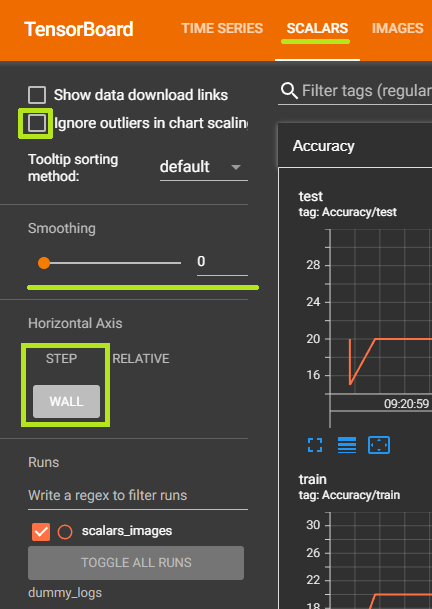

Erwartetes Bild in Tensorboard:

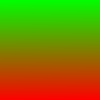


In [ ]:
import time
import numpy as np

In [ ]:
# Speziell für diese Demo: 
# Um aufzuräumen und saubere Tensorboard Instanzen zu haben, werden alte Instanzen zunächst gelöscht.
# Für Testzwecke: Alte Tensorboard Instanzen schließen und alte Eventfiles löschen 
from tensorboard import manager
infos = manager.get_all()
for info in infos:
  !kill $info.pid

from glob import glob
event_files = glob('dummy_logs/scalars_images/events*')
for f in event_files:
  print(f'deleting {f}')
  !rm $f

# Ab hier relevanter Code für Tensorboard
from torch.utils import tensorboard
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

### SummaryWriter Instanz ###
# SummaryWriter schreibt Ausgaben in log_dir
log_dir = "dummy_logs/scalars_images"
writer = SummaryWriter(log_dir)

### Anzeige von Scalarwerten z.B. Loss und Accuray ###
# Step 0
writer.add_scalar('loss/train', 5, 0)
writer.add_scalar('loss/test', 10, 0)

# Step 1
writer.add_scalar('loss/train', 2.5, 1) 
writer.add_scalar('loss/test', 5, 1)

# Step 2 immer wieder überschreiben
for _ in range(10):
  time.sleep(0.1)
  writer.add_scalar('loss/train', 1, 2) 
  writer.add_scalar('loss/test', 1, 2)

# Step 2 wieder überschreiben
writer.add_scalar('loss/train', 0.5, 2) 
writer.add_scalar('loss/test', 0.5, 2)


### Bilder hinzufügen ###
# Tensorboard nutzt das standard Tensor Format (C,H,W).
# Normale Bilder (H,W,C) können auch angegeben werden.
normal_image = np.zeros((100, 100, 3))
normal_image[:, :, 0] = np.arange(0, 10000).reshape(100, 100) / 10000
normal_image[:, :, 1] = 1 - np.arange(0, 10000).reshape(100, 100) / 10000
tensor_image = normal_image.transpose(2, 0, 1)

writer.add_image('normal_image', normal_image, 0, dataformats='HWC')
writer.add_image('tensor_image', tensor_image, 0)

# Writer schließen
writer.close()

# Start Tensorboard
%tensorboard --logdir=dummy_logs

Aufgabe 1.2 (Tensorboard) | Gegeben ist folgendes einfaches Modell `(SimpleConv)`. Lassen Sie sich den Modellgraphen in Tensorboard anzeigen. Durch die Angabe von Beispieldaten, lässt sich der Fuss der Daten im Graphen gut nachvollziehen. Ein- und Ausgabegrößen finden sich sowohl auf allen Verbindungen, sowie in einer Detailübersicht des ausgewählten Knoten.

Sie müssen keine neue Tensorboard Session starten und können auf die alte Session aus der ersten Aufgabe zurückgreifen. Ggf. ist ein Refresh (oben rechts in der Menüleiste von Tensorboard) notwendig.


In [ ]:
from torch import nn
import torch

class SimpleConv(nn.Module):
  def __init__(self):
    super(SimpleConv, self).__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(1, 6, 3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(2, 2),
    ) 

    self.fc = nn.Sequential(
      nn.Linear(6 * 14 * 14, 10),
    )

  def forward(self, x):
    x = self.conv(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

In [ ]:
model = SimpleConv()
example_data = torch.zeros(12, 1, 28, 28) # BatchSize,C,H,W
log_dir = "dummy_logs/model_graph"

writer = SummaryWriter(log_dir)
writer.add_graph(model, example_data)

writer.close()

Aufgabe 1.3 (Tensorboard) | Gegeben ist Teil des [Codes](https://colab.research.google.com/github/smartgeometry-ucl/dl4g/blob/master/autoencoder.ipynb#scrollTo=WEFnyrKM1SRu) eines [Autoencoders](https://de.wikipedia.org/wiki/Autoencoder). Wählen Sie eine GPU-Runtime.

Der Autoencoder besteht aus zwei Teilen und hat hier folgende Dimensionen:
1.   Encoder: Mappt den Input `(28x28)` Bilder in einen Latent Space mit `10` Elementen. Diese entsprechen nicht den 10 MNIST Klassen!
2.   Decoder: Mappt den Latent Space `(10)` wieder zurück auf `(28x28)` Bilder

Loggen Sie in Tensorbaord folgende Informationen, der `writer` ist im Abschnitt `Trainingscode` bereits erstellt:
*   Loss für jeden Batch (nicht sinnvoll für richtige Anwendungen, da die Datenmenge viel zu groß wird! Aufgrund der wenigen Batches und des schnellen Trainings, liefert es hier eine gute Detailansicht.)
*   Loss pro Epoche
*   Jeweils für den ersten Batch jeder Epoche Samples der Input- und Outputbilder. Sie können die Hilfsfunktionen `vi` und `vo` verwenden.



In [ ]:
# Parameter
latent_dims = 10
capacity = 64
num_epochs = 5
batch_size = 128
learning_rate = 1e-3
use_gpu = True

In [ ]:
# Daten und Hilfsfunktionen (vi, vo)
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    return x

# draw grid from input batch
def vi(images):
    img = torchvision.utils.make_grid(images[1:50], 10, 5)
    img = img.cpu()
    img = to_img(img)
    np_imagegrid = img.numpy()
    return np_imagegrid

# draw grid from output batch
def vo(images, model):
    with torch.no_grad():
        images = images.to(device)
        images = model(images)
        images = images.cpu()
        images = to_img(images)
        np_imagegrid = torchvision.utils.make_grid(images[1:50], 10, 5).numpy()
        return np_imagegrid

In [ ]:
# Autoencoder Modell
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
            
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.tanh(self.conv1(x)) # last layer before output is tanh, since the images are normalized and 0-centered
        return x
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon
    
autoencoder = Autoencoder()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
autoencoder = autoencoder.to(device)

num_params = sum(p.numel() for p in autoencoder.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

In [ ]:
# Tensorboard laden
from tensorboard import manager
infos = manager.get_all()
for info in infos:
  !kill $info.pid
%tensorboard --logdir=logs

In [ ]:
from torch.utils.tensorboard import SummaryWriter

log_dir = "logs"
writer = SummaryWriter(log_dir)

optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

# set to training mode
autoencoder.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    for image_batch, _ in train_dataloader:
        
        image_batch = image_batch.to(device)
        
        # autoencoder reconstruction
        image_batch_recon = autoencoder(image_batch)
        
        # reconstruction error
        loss = F.mse_loss(image_batch_recon, image_batch)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        
        if num_batches == 0:  
          input_grid = vi(image_batch)
          output_grid = vo(image_batch, autoencoder)
          writer.add_image('vis/input', input_grid, epoch)
          writer.add_image('vis/output', output_grid, epoch)

        writer.add_scalar('_loss/train', loss, epoch)
        num_batches += 1
        
    train_loss_avg[-1] /= num_batches
    writer.add_scalar('loss/train', train_loss_avg[-1], epoch)
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

writer.close()

Aufgabe 1.4 (Tensorboard) | Tensorboard bietet noch viele weitere Möglichkeiten, Dinge im Zusammenhang mit Datenfluss, Statistik, Modellen und noch viele weiteren, darzustellen. Bei Interesse gibt es [hier](https://www.tensorflow.org/tensorboard) viele weitere Infos und Beispiele.

Auch oft hilfreich, unter Settings kann eingestellt werden, dass sich Tensorboard zyklisch updatet.

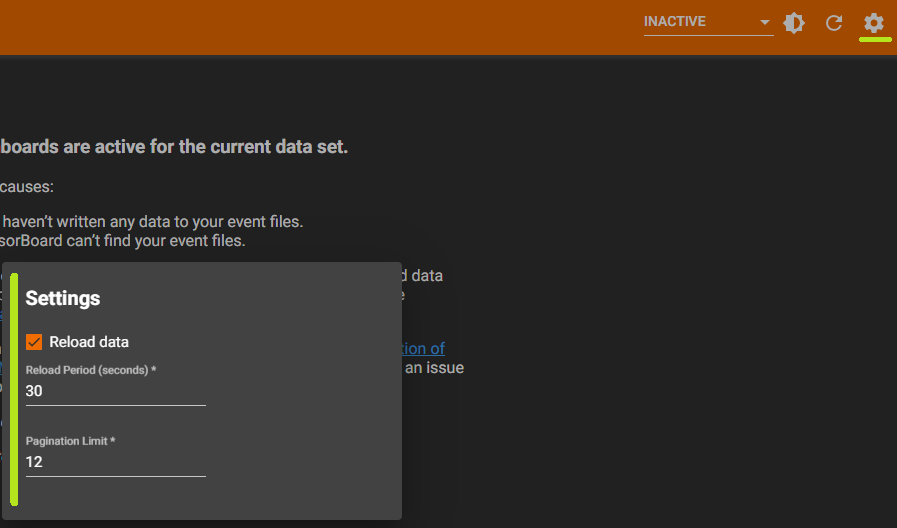